In [2]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import pathlib
import csv
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras import layers
import keras
from keras.models import Sequential 
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.layers import Flatten
from keras.layers import Dropout
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [3]:
#DataFlair - Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#DataFlair - Emotions to observe
#observed_emotions=['calm', 'happy', 'fearful', 'disgust']
x,c,z=[],[],[]

header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1,21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
print(header)

['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


In [4]:
file = open('/Users/anuhyakalvakala/Desktop/dataset.csv', 'w', newline='')
#print(file)
with file:
    writer = csv.writer(file)
    writer.writerow(header)
for folder in os.listdir(f'/Users/anuhyakalvakala/Downloads/speech-emotion-recognition-ravdess-data/'):
    #print(folder,'folder')
    if folder != '.DS_Store' :
        for filename in os.listdir(f'/Users/anuhyakalvakala/Downloads/speech-emotion-recognition-ravdess-data/{folder}'):
        #print(filename,'filename')
            songname = f'/Users/anuhyakalvakala/Downloads/speech-emotion-recognition-ravdess-data/{folder}/{filename}'
            file_name=os.path.basename(filename)
            emotion=emotions[file_name.split("-")[2]]
            #if emotion not in observed_emotions:
            #    continue
            # feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
            # x.append(feature)
            c = emotion
            y, sr = librosa.load(songname, mono=True, duration=300)
            rmse = librosa.feature.rms(y=y)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            to_append += f' {c}'
            file = open('/Users/anuhyakalvakala/Desktop/dataset.csv', 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())

In [9]:
data = pd.read_csv('/Users/anuhyakalvakala/Desktop/dataset.csv')
data.head()
#print(data)
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)#Scaling the Feature columns
# integer_encoded= encoder.fit_transform(genre_list)#Scaling the Feature columns
# integer_encoded = encoder.reshape(len(y), 1)
# onehot_encoder = OneHotEncoder(sparse=False)
# onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
ohe = OneHotEncoder()
transformed = ohe.fit_transform(data[['label']])
print(transformed.toarray())
# y = label_binarize(genre_list, classes=[0, 1, 2,3,4,5,6,7])
# n_classes = y.shape[1]
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
n_samples, n_features = X.shape
n_classes = transformed.toarray().shape[1]
#print(X)
#print(genre_list)
print(y[1])


[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
3


In [10]:
print(transformed.toarray())

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [11]:
data.shape

(1440, 27)

In [12]:
X

array([[-1.22052089,  0.07402641,  0.75734193, ..., -1.96126771,
        -1.24288987, -0.44521078],
       [-2.01921417, -0.15642398, -0.60233612, ..., -0.49196017,
        -0.90982587, -0.92095534],
       [-0.95263075,  2.34813105,  2.05055601, ...,  3.82001591,
         1.76421763,  1.31928215],
       ...,
       [ 0.68070575, -0.70090378, -0.78973125, ...,  1.74461255,
         1.0226038 ,  0.82609376],
       [ 1.06834316, -0.65902022, -1.31679659, ...,  1.44153403,
         0.93767714,  0.99978918],
       [ 0.78210054, -0.59563516, -1.27101536, ...,  1.56444361,
         0.76109551,  0.71525324]])

In [13]:
#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
print(x_traincnn.shape, x_testcnn.shape)

(1152, 26, 1) (288, 26, 1)


In [39]:
#model training
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Flatten())
model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(48, activation='relu'))
# model.add(Dropout(0.2))
#model.add(Flatten())
#model.add(layers.Dense(24, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))
print(model.summary)
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
classifier = model.fit(X_train,y_train,epochs=100,batch_size=128,validation_data=(x_testcnn, y_test))

# lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
# lm.fit(X_train, y_train)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x29899d1e0>>


2022-12-04 17:54:58.726995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-04 17:54:58.728386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2022-12-04 17:54:59.093216: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-04 17:54:59.355161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 29ms/step - loss: 2.0134 - accuracy: 0.2405 - val_loss: 1.8511 - val_accuracy: 0.3576
Epoch 2/100
9/9 [==============================] - 0s 9ms/step - loss: 1.8051 - accuracy: 0.3568 - val_loss: 1.6766 - val_accuracy: 0.3785
Epoch 3/100
1/9 [==>...........................] - ETA: 0s - loss: 1.7120 - accuracy: 0.4375

2022-12-04 17:54:59.999619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 9ms/step - loss: 1.6476 - accuracy: 0.3967 - val_loss: 1.5425 - val_accuracy: 0.4444
Epoch 4/100
9/9 [==============================] - 0s 9ms/step - loss: 1.5186 - accuracy: 0.4384 - val_loss: 1.4540 - val_accuracy: 0.4583
Epoch 5/100
9/9 [==============================] - 0s 8ms/step - loss: 1.4040 - accuracy: 0.4931 - val_loss: 1.3904 - val_accuracy: 0.4757
Epoch 6/100
9/9 [==============================] - 0s 8ms/step - loss: 1.3129 - accuracy: 0.5278 - val_loss: 1.3183 - val_accuracy: 0.5139
Epoch 7/100
9/9 [==============================] - 0s 10ms/step - loss: 1.2121 - accuracy: 0.5729 - val_loss: 1.2711 - val_accuracy: 0.5312
Epoch 8/100
9/9 [==============================] - 0s 11ms/step - loss: 1.1277 - accuracy: 0.6181 - val_loss: 1.2507 - val_accuracy: 0.5312
Epoch 9/100
9/9 [==============================] - 0s 9ms/step - loss: 1.0509 - accuracy: 0.6363 - val_loss: 1.1719 - val_accuracy: 0.5694
Epoch 10/100
9/9 [===================

In [40]:
#prediction 
predictions = model.predict(X_test).argmax(axis=1)
#pred_prob = model.predict_proba(X_test)
predict_prob=model.predict(X_test)
predict_classes=np.argmax(predict_prob,axis=1)
new_y_test = y_test.astype(int)
print(predict_prob)

9/9 [==============================] - 0s 2ms/step
[[5.2654384e-16 6.7187627e-31 9.5892007e-16 ... 3.5606987e-25
  1.5339189e-12 3.8229198e-30]
 [1.3194844e-03 4.9670354e-02 1.8206274e-04 ... 3.0530842e-05
  4.1266824e-03 1.5388795e-06]
 [2.1218486e-06 6.0599525e-09 9.4144487e-01 ... 9.7405712e-07
  3.4802292e-02 2.1850459e-02]
 ...
 [3.7030183e-04 1.4118931e-12 3.8017071e-05 ... 7.3220298e-11
  2.5746108e-06 9.5452106e-01]
 [9.2345928e-08 3.7134529e-10 9.1469991e-11 ... 4.3582840e-10
  1.8637256e-07 5.7869238e-06]
 [1.1109590e-03 7.5181429e-06 3.9316517e-05 ... 2.4860425e-02
  1.2599789e-04 9.1192663e-01]]


2022-12-04 17:56:16.280969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [41]:
#accuracy
accuracy=accuracy_score(y_true=new_y_test, y_pred=predictions)
print('Accuracy of neural network',accuracy)

Accuracy of neural network 0.6736111111111112


              precision    recall  f1-score   support

           0       0.85      0.79      0.82        52
           1       0.78      0.78      0.78        32
           2       0.62      0.62      0.62        34
           3       0.72      0.67      0.70        43
           4       0.68      0.74      0.71        35
           5       0.52      0.80      0.63        15
           6       0.59      0.59      0.59        34
           7       0.74      0.67      0.71        43

    accuracy                           0.70       288
   macro avg       0.69      0.71      0.69       288
weighted avg       0.71      0.70      0.71       288

Confusion Matrix of neural networks
[[41  0  5  1  4  0  0  1]
 [ 2 25  1  0  0  3  1  0]
 [ 1  3 21  2  1  2  1  3]
 [ 0  0  2 29  3  0  5  4]
 [ 1  0  2  4 26  0  1  1]
 [ 0  1  0  0  0 12  2  0]
 [ 1  3  0  4  1  4 20  1]
 [ 2  0  3  0  3  2  4 29]]


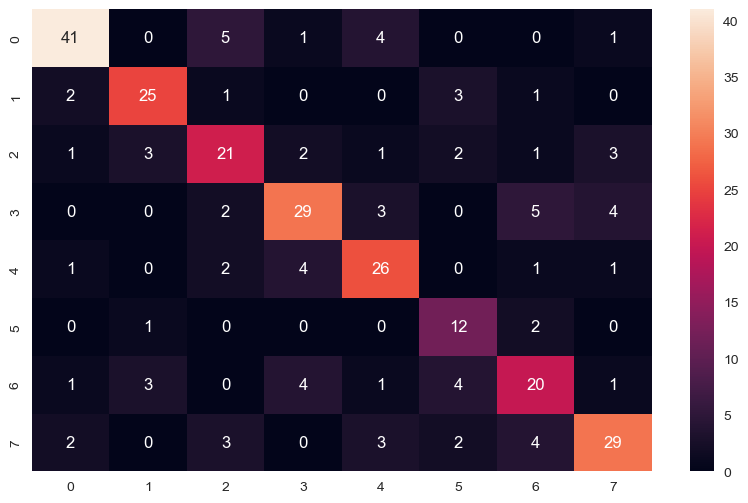

In [140]:
#log loss
# logloss = metrics.log_loss(new_y_test,predictions)
# print(logloss)
#confusion matrix
matrix = confusion_matrix(new_y_test, predictions)
print(classification_report(new_y_test, predictions))
print('Confusion Matrix of neural networks')
print(matrix)
# plt.figure()
# plot_confusion_matrix(matrix,new_y_test,X)
# plt.show()
fig, ax = plt.subplots(figsize=(10, 6))
# ax.set_title('Confusion Matrx for neural network')
# ax.set_xlabel('Time label')
# ax.set_ylabel('predicted label')
plt.xlabel('X Axis', axes=ax)
plt.ylabel('Y Axis', axes=ax)

f = sns.heatmap(matrix, annot=True, fmt='d')

Text(97.72222222222221, 0.5, 'Time label')

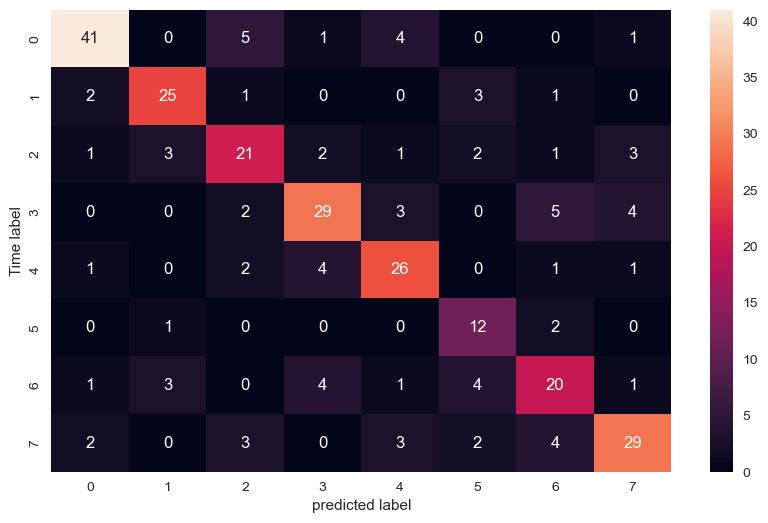

In [145]:
fig, ax = plt.subplots(figsize=(10, 6))
# ax.set_title('Confusion Matrx for neural network')
# ax.set_xlabel('Time label')
# ax.set_ylabel('predicted label')
f = sns.heatmap(matrix, annot=True, fmt='d')
plt.xlabel('predicted label', axes=ax)
plt.ylabel('Time label', axes=ax)


In [44]:
#roc_auc score and curve
roc_score = roc_auc_score(new_y_test,predict_prob,multi_class='ovr')
print(roc_score)
# fpr,tpr,thresh = roc_curve(y_test,predict_prob,multi_class='ovr')
# plt.plot([0,1],[1,0],linestyle='--')
# plt.plot(fpr,tpr,marker='-',color='r')
# Compute ROC curve and ROC area for each class
# fpr, tpr, _ = metrics.roc_curve(y_test, predict_prob)
# auc = round(metrics.roc_auc_score(y_test, predict_prob), 4)
# plt.plot(fpr,tpr,label="neural network, AUC="+str(auc))

0.9341288816732738


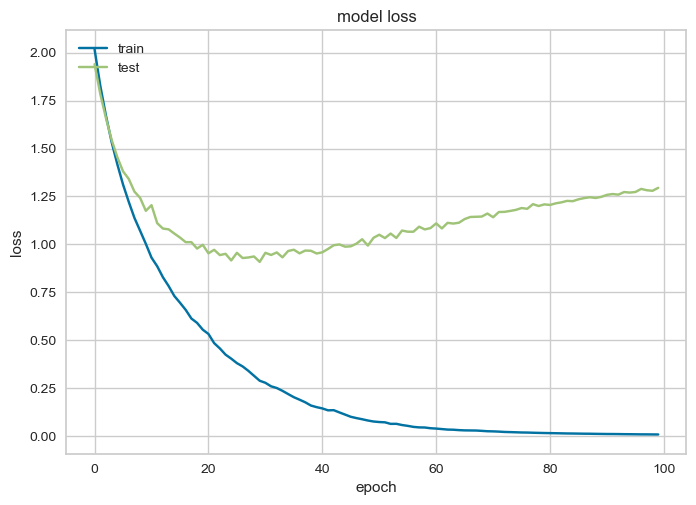

In [115]:
 # Loss plotting
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')



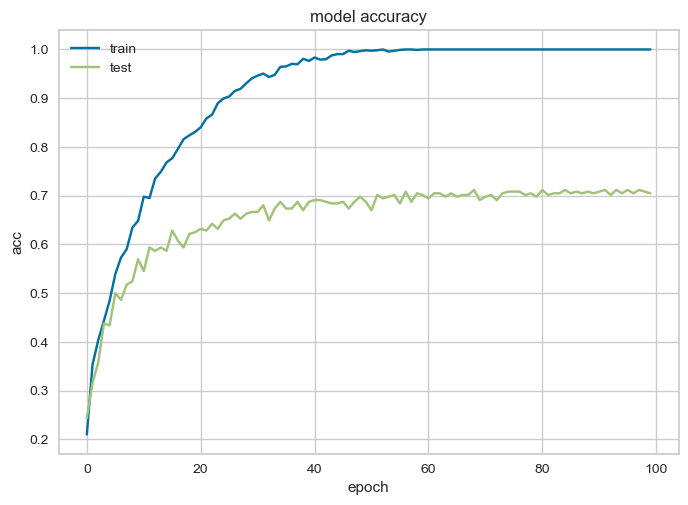

In [113]:
 # Accuracy plotting
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

k means

In [146]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

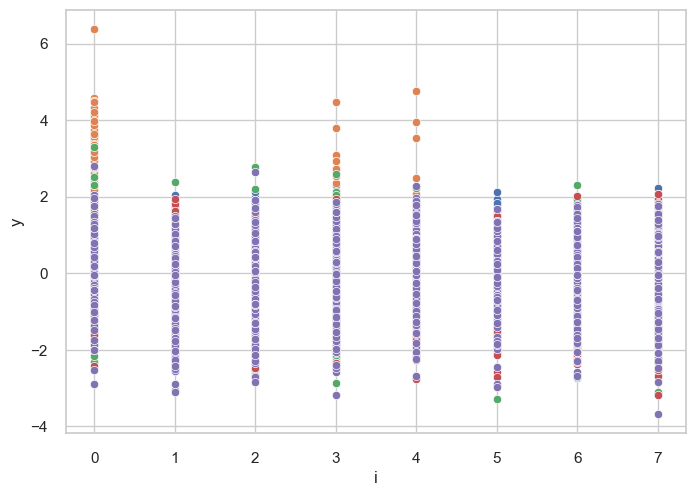

In [233]:
centers = 5
# X_train, true_labels = make_blobs(n_samples=data, centers=centers, random_state=42)
# X_train = StandardScaler().fit_transform(X_train)
sns.scatterplot(y=[X[0] for X in X_train] ,x=[y for y in y_train],palette="deep",legend=None)
sns.scatterplot(y=[X[1] for X in X_train] ,x=[y for y in y_train],palette="deep",legend=None)
sns.scatterplot(y=[X[2] for X in X_train] ,x=[y for y in y_train],palette="deep",legend=None)
sns.scatterplot(y=[X[3] for X in X_train] ,x=[y for y in y_train],palette="deep",legend=None)
sns.scatterplot(y=[X[4] for X in X_train] ,x=[y for y in y_train],palette="deep",legend=None)
plt.xlabel("centriods")
plt.ylabel("y")
plt.show()

In [43]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# model=LogisticRegression(random_state=42)):
# km = model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
n_clusters = len(np.unique(y_train))
print(n_clusters)

# K = range(2,10)

# for k in K:
clf = KMeans(n_clusters = n_clusters, random_state=42)
fit = clf.fit(X_train)
y_labels_train = clf.labels_
y_labels_test = clf.predict(X_test)
# if output == 'add':
#     X_train['km_clust'] = y_labels_train
#     X_test['km_clust'] = y_labels_test
# elif output == 'replace':
#     X_train = y_labels_train[:, np.newaxis]
#     X_test = y_labels_test[:, np.newaxis]
# else:
#     raise ValueError('output should be either add or replace')


8


AxisError: axis 1 is out of bounds for array of dimension 1

In [45]:
new_y_test

array([4, 4, 7, 4, 2, 1, 6, 1, 1, 4, 2, 2, 4, 1, 6, 4, 3, 6, 1, 0, 4, 0,
       4, 3, 6, 4, 3, 1, 3, 3, 6, 1, 0, 0, 0, 2, 2, 0, 6, 0, 0, 7, 6, 3,
       6, 7, 2, 2, 3, 1, 1, 3, 1, 6, 2, 1, 5, 3, 7, 5, 3, 3, 2, 2, 6, 6,
       3, 1, 3, 2, 2, 4, 4, 3, 2, 5, 0, 5, 4, 6, 1, 0, 5, 1, 3, 6, 5, 0,
       6, 6, 6, 3, 0, 5, 1, 1, 6, 2, 3, 1, 3, 7, 6, 3, 1, 6, 6, 3, 6, 6,
       0, 2, 4, 1, 2, 0, 2, 2, 1, 2, 7, 5, 0, 6, 2, 6, 0, 7, 4, 4, 0, 3,
       7, 6, 6, 6, 4, 1, 0, 2, 3, 7, 7, 0, 3, 5, 2, 4, 0, 7, 6, 7, 6, 4,
       5, 5, 0, 7, 1, 0, 2, 6, 3, 4, 7, 7, 1, 1, 2, 7, 4, 1, 2, 1, 3, 7,
       1, 6, 6, 4, 4, 4, 2, 7, 2, 4, 4, 4, 0, 2, 6, 7, 3, 3, 4, 5, 0, 2,
       2, 4, 1, 7, 5, 3, 2, 1, 4, 0, 7, 3, 2, 1, 4, 1, 4, 1, 6, 1, 2, 2,
       3, 7, 6, 6, 3, 7, 0, 0, 2, 2, 4, 7, 6, 0, 7, 3, 1, 5, 1, 7, 0, 7,
       7, 5, 7, 0, 5, 2, 4, 1, 1, 1, 7, 3, 0, 6, 3, 2, 0, 2, 6, 7, 5, 5,
       7, 0, 3, 2, 4, 1, 5, 0, 4, 7, 7, 4, 3, 2, 0, 7, 1, 0, 1, 2, 2, 7,
       4, 7])

In [46]:
y_labels_test

array([6, 1, 1, 5, 5, 1, 7, 4, 7, 4, 5, 1, 7, 3, 5, 7, 3, 7, 7, 0, 7, 0,
       7, 4, 7, 6, 5, 3, 2, 6, 1, 4, 2, 6, 0, 4, 4, 2, 3, 0, 5, 1, 1, 2,
       4, 5, 5, 7, 0, 7, 1, 5, 3, 7, 4, 4, 3, 1, 4, 4, 4, 2, 5, 5, 5, 4,
       0, 5, 5, 7, 1, 0, 5, 3, 7, 3, 5, 4, 5, 4, 7, 0, 7, 7, 7, 7, 5, 2,
       3, 5, 4, 2, 0, 3, 3, 4, 3, 3, 1, 3, 1, 4, 1, 0, 4, 1, 3, 7, 4, 3,
       2, 7, 1, 7, 3, 0, 5, 7, 3, 3, 5, 5, 6, 6, 1, 1, 3, 0, 7, 1, 1, 2,
       1, 7, 0, 5, 2, 7, 2, 7, 2, 2, 7, 6, 2, 7, 7, 0, 1, 4, 2, 2, 3, 5,
       3, 3, 2, 4, 5, 4, 1, 3, 0, 5, 2, 5, 7, 3, 4, 1, 5, 1, 1, 5, 6, 1,
       3, 3, 1, 0, 0, 7, 5, 5, 5, 3, 0, 4, 1, 5, 3, 0, 6, 1, 5, 5, 5, 7,
       7, 6, 3, 0, 3, 3, 3, 3, 3, 0, 5, 2, 5, 7, 7, 3, 2, 5, 2, 3, 5, 5,
       1, 2, 7, 7, 0, 4, 7, 1, 7, 7, 4, 5, 5, 1, 5, 1, 4, 3, 4, 7, 7, 5,
       1, 3, 5, 7, 5, 5, 0, 7, 3, 3, 5, 6, 0, 0, 5, 0, 1, 7, 6, 2, 7, 3,
       4, 1, 5, 7, 1, 7, 1, 0, 0, 0, 3, 6, 6, 2, 5, 4, 3, 4, 3, 3, 3, 2,
       4, 7], dtype=int32)

In [51]:
y_true = np.argmax(y_test, axis=0)

In [52]:
roc_score = roc_auc_score(y_true,y_labels_test,multi_class='ovr')
print(roc_score)

TypeError: Singleton array array(2) cannot be considered a valid collection.

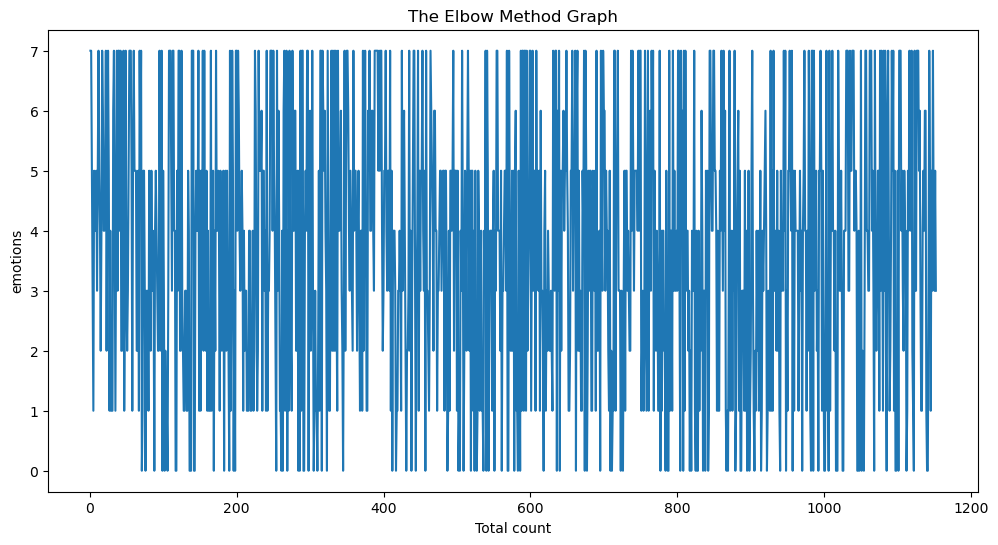

In [16]:
plt.subplots(figsize=(12, 6))
plt.plot(range(1,1153),y_labels_train)
plt.title('The Elbow Method Graph')
plt.xlabel('Total count')
plt.ylabel('emotions')
plt.show()

In [21]:
y

array([0, 3, 3, ..., 1, 1, 5])

In [23]:
X

array([[-1.22052089,  0.07402641,  0.75734193, ..., -1.96126771,
        -1.24288987, -0.44521078],
       [-2.01921417, -0.15642398, -0.60233612, ..., -0.49196017,
        -0.90982587, -0.92095534],
       [-0.95263075,  2.34813105,  2.05055601, ...,  3.82001591,
         1.76421763,  1.31928215],
       ...,
       [ 0.68070575, -0.70090378, -0.78973125, ...,  1.74461255,
         1.0226038 ,  0.82609376],
       [ 1.06834316, -0.65902022, -1.31679659, ...,  1.44153403,
         0.93767714,  0.99978918],
       [ 0.78210054, -0.59563516, -1.27101536, ...,  1.56444361,
         0.76109551,  0.71525324]])

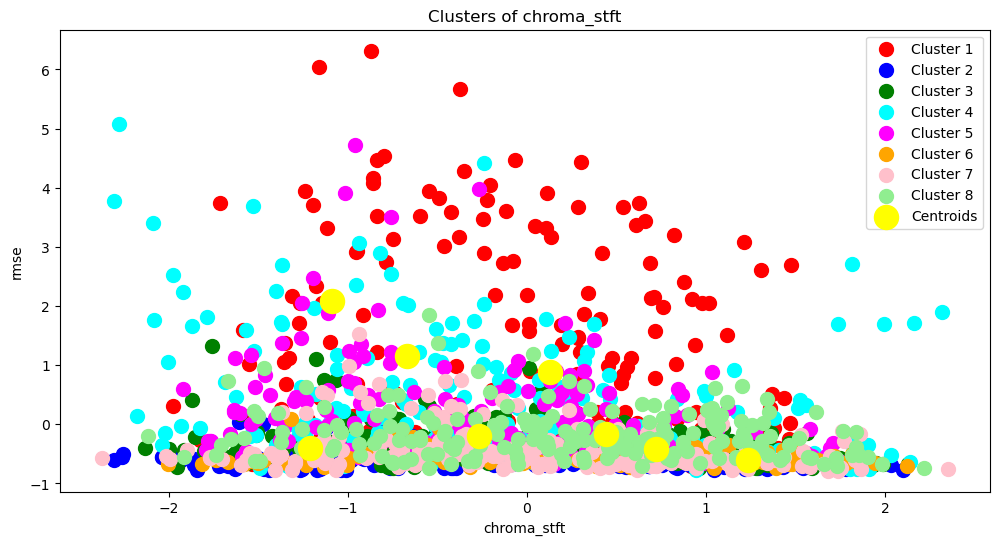

In [17]:
#6 Visualising the clusters
plt.subplots(figsize=(12, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y==1, 0], X[y==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y==2, 0], X[y==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y==3, 0], X[y==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y==4, 0], X[y==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.scatter(X[y==5, 0], X[y==5, 1], s=100, c='orange', label ='Cluster 6')
plt.scatter(X[y==6, 0], X[y==6, 1], s=100, c='pink', label ='Cluster 7')
plt.scatter(X[y==7, 0], X[y==7, 1], s=100, c='lightgreen', label ='Cluster 8')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('Clusters of chroma_stft')
plt.xlabel('chroma_stft')
plt.ylabel('rmse')
plt.legend()
plt.show()

In [20]:
print(X[y==0, 0][0])
print(X[y==0, 1][0])

-1.2205208929997002
0.07402641147213669


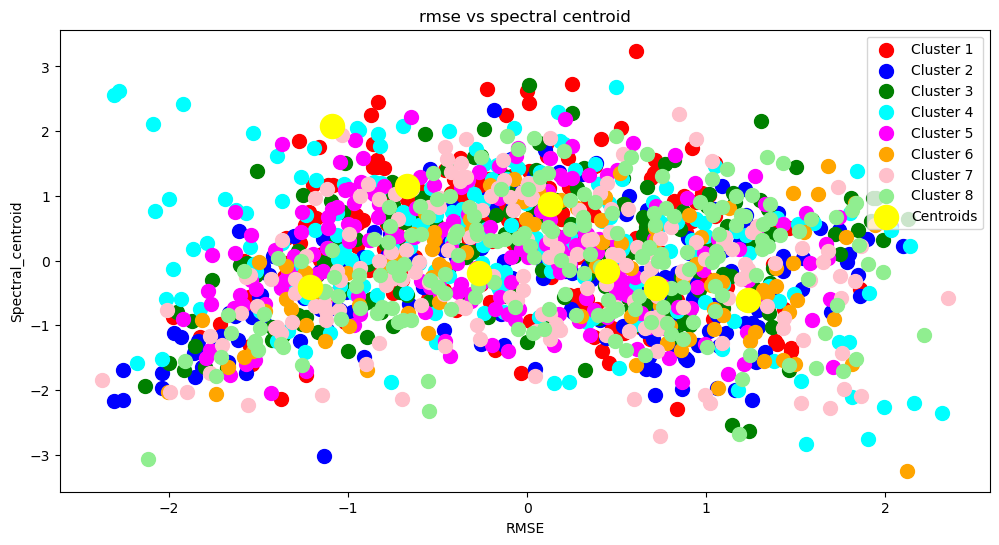

In [31]:
#6 Visualising the clusters
plt.subplots(figsize=(12, 6))
plt.scatter(X[y==0, 0], X[y==0, 2], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y==1, 0], X[y==1, 2], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y==2, 0], X[y==2, 2], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y==3, 0], X[y==3, 2], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y==4, 0], X[y==4, 2], s=100, c='magenta', label ='Cluster 5')
plt.scatter(X[y==5, 0], X[y==5, 2], s=100, c='orange', label ='Cluster 6')
plt.scatter(X[y==6, 0], X[y==6, 2], s=100, c='pink', label ='Cluster 7')
plt.scatter(X[y==7, 0], X[y==7, 2], s=100, c='lightgreen', label ='Cluster 8')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('rmse vs spectral centroid')
plt.xlabel('RMSE')
plt.ylabel('Spectral_centroid')
plt.legend()
plt.show()

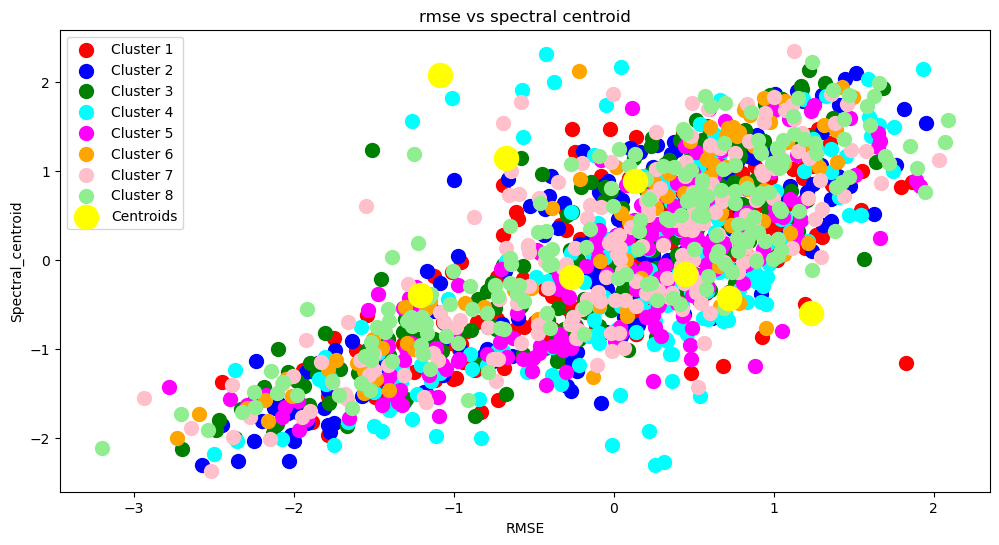

In [32]:
#6 Visualising the clusters
plt.subplots(figsize=(12, 6))
plt.scatter(X[y==0, 3], X[y==0, 0], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y==1, 3], X[y==1, 0], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y==2, 3], X[y==2, 0], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y==3, 3], X[y==3, 0], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y==4, 3], X[y==4, 0], s=100, c='magenta', label ='Cluster 5')
plt.scatter(X[y==5, 3], X[y==5, 0], s=100, c='orange', label ='Cluster 6')
plt.scatter(X[y==6, 3], X[y==6, 0], s=100, c='pink', label ='Cluster 7')
plt.scatter(X[y==7, 3], X[y==7, 0], s=100, c='lightgreen', label ='Cluster 8')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('rmse vs spectral centroid')
plt.xlabel('RMSE')
plt.ylabel('Spectral_centroid')
plt.legend()
plt.show()

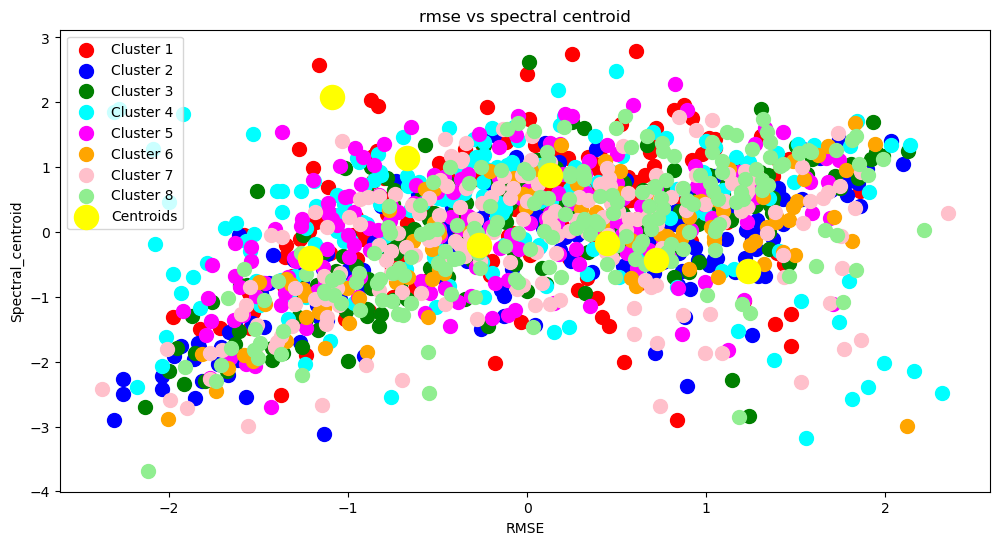

In [33]:
#6 Visualising the clusters
plt.subplots(figsize=(12, 6))
plt.scatter(X[y==0, 0], X[y==0, 4], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y==1, 0], X[y==1, 4], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y==2, 0], X[y==2, 4], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y==3, 0], X[y==3, 4], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y==4, 0], X[y==4, 4], s=100, c='magenta', label ='Cluster 5')
plt.scatter(X[y==5, 0], X[y==5, 4], s=100, c='orange', label ='Cluster 6')
plt.scatter(X[y==6, 0], X[y==6, 4], s=100, c='pink', label ='Cluster 7')
plt.scatter(X[y==7, 0], X[y==7, 4], s=100, c='lightgreen', label ='Cluster 8')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('rmse vs spectral centroid')
plt.xlabel('RMSE')
plt.ylabel('Spectral_centroid')
plt.legend()
plt.show()

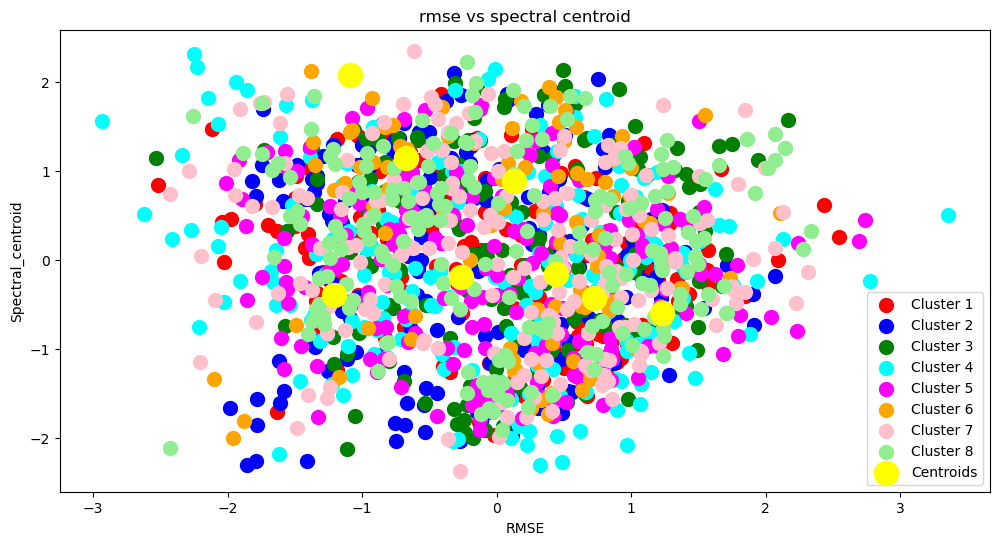

In [34]:
#6 Visualising the clusters
plt.subplots(figsize=(12, 6))
plt.scatter(X[y==0, 5], X[y==0, 0], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y==1, 5], X[y==1, 0], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y==2, 5], X[y==2, 0], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y==3, 5], X[y==3, 0], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y==4, 5], X[y==4, 0], s=100, c='magenta', label ='Cluster 5')
plt.scatter(X[y==5, 5], X[y==5, 0], s=100, c='orange', label ='Cluster 6')
plt.scatter(X[y==6, 5], X[y==6, 0], s=100, c='pink', label ='Cluster 7')
plt.scatter(X[y==7, 5], X[y==7, 0], s=100, c='lightgreen', label ='Cluster 8')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('rmse vs spectral centroid')
plt.xlabel('RMSE')
plt.ylabel('Spectral_centroid')
plt.legend()
plt.show()

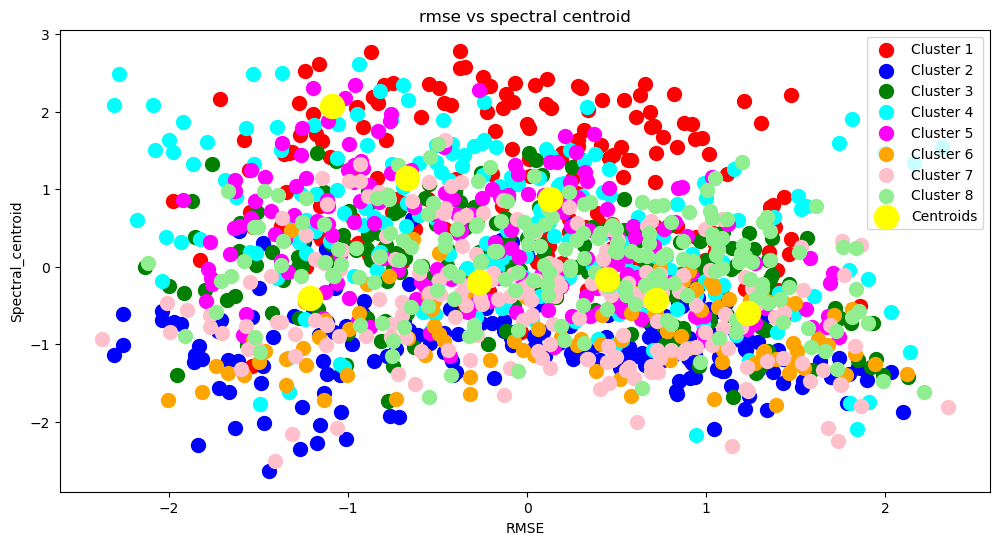

In [35]:
#6 Visualising the clusters
plt.subplots(figsize=(12, 6))
plt.scatter(X[y==0, 0], X[y==0, 6], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y==1, 0], X[y==1, 6], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y==2, 0], X[y==2, 6], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y==3, 0], X[y==3, 6], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y==4, 0], X[y==4, 6], s=100, c='magenta', label ='Cluster 5')
plt.scatter(X[y==5, 0], X[y==5, 6], s=100, c='orange', label ='Cluster 6')
plt.scatter(X[y==6, 0], X[y==6, 6], s=100, c='pink', label ='Cluster 7')
plt.scatter(X[y==7, 0], X[y==7, 6], s=100, c='lightgreen', label ='Cluster 8')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('rmse vs spectral centroid')
plt.xlabel('RMSE')
plt.ylabel('Spectral_centroid')
plt.legend()
plt.show()

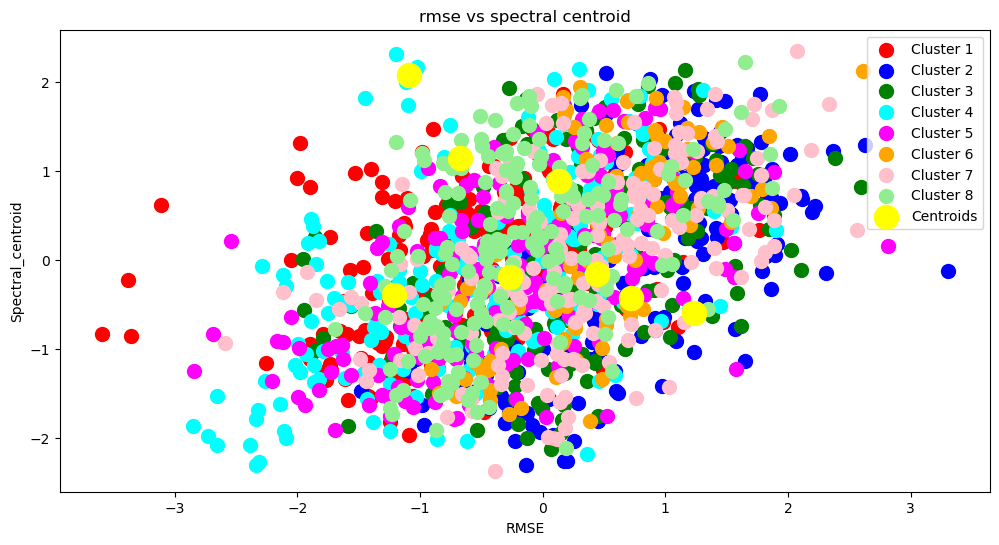

In [36]:
#6 Visualising the clusters
plt.subplots(figsize=(12, 6))
plt.scatter(X[y==0, 7], X[y==0, 0], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y==1, 7], X[y==1, 0], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y==2, 7], X[y==2, 0], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y==3, 7], X[y==3, 0], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y==4, 7], X[y==4, 0], s=100, c='magenta', label ='Cluster 5')
plt.scatter(X[y==5, 7], X[y==5, 0], s=100, c='orange', label ='Cluster 6')
plt.scatter(X[y==6, 7], X[y==6, 0], s=100, c='pink', label ='Cluster 7')
plt.scatter(X[y==7, 7], X[y==7, 0], s=100, c='lightgreen', label ='Cluster 8')
#Plot the centroid. This time we're going to use the cluster centres  #attribute that returns here the coordinates of the centroid.
plt.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], s=300, c='yellow', label = 'Centroids')
plt.title('rmse vs spectral centroid')
plt.xlabel('RMSE')
plt.ylabel('Spectral_centroid')
plt.legend()
plt.show()

In [119]:
X[0]

array([-1.22052089,  0.07402641,  0.75734193, -0.68324596,  0.01071981,
        0.50110796,  0.43973974, -0.85176025,  0.03674091, -0.43648851,
       -1.22376957, -0.12644614, -0.52874004, -0.42021352, -1.11173584,
        0.15005614, -0.84782604, -0.7203991 , -0.19115624, -1.19131485,
       -0.96710367, -1.13794675,  0.33621663, -1.96126771, -1.24288987,
       -0.44521078])

In [65]:
clf.score(X_test, y_test)

-3568.484324511784

In [69]:
print(classification_report(y_test, y_labels_test))

              precision    recall  f1-score   support

           0       0.40      0.10      0.16        41
           1       0.15      0.16      0.15        38
           2       0.03      0.03      0.03        37
           3       0.07      0.08      0.08        36
           4       0.15      0.08      0.10        38
           5       0.02      0.06      0.03        16
           6       0.24      0.26      0.25        42
           7       0.23      0.23      0.23        40

    accuracy                           0.13       288
   macro avg       0.16      0.12      0.13       288
weighted avg       0.18      0.13      0.14       288



Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

In [56]:
lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
lm.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [57]:
print('Predicted value is =', lm.predict([X_test[200]]))

print('Actual value from test data is %s ' % (y_test[200]) )

Predicted value is = [6]
Actual value from test data is 1 


In [58]:
y_score = lm.predict(X_test)

In [59]:
lm.score(X_test, y_test)

0.5243055555555556

In [60]:
roc_score = roc_auc_score(y_true,y_score,multi_class='ovr')
print(roc_score)

TypeError: Singleton array array(2) cannot be considered a valid collection.

In [61]:
print(classification_report(y_test, y_score))

              precision    recall  f1-score   support

           0       0.62      0.78      0.69        36
           1       0.49      0.80      0.61        41
           2       0.57      0.56      0.56        43
           3       0.52      0.42      0.46        36
           4       0.46      0.35      0.40        37
           5       0.33      0.11      0.16        19
           6       0.44      0.44      0.44        39
           7       0.59      0.51      0.55        37

    accuracy                           0.52       288
   macro avg       0.50      0.50      0.48       288
weighted avg       0.51      0.52      0.51       288



array([[31,  0,  7,  4,  3,  0,  2,  5],
       [ 1, 20,  5,  0,  0,  1,  5,  0],
       [ 1,  2, 22,  1,  1,  0,  2,  5],
       [ 3,  1,  4, 13,  7,  2,  6,  7],
       [ 2,  1,  3,  6, 15,  1,  4,  3],
       [ 0,  2,  0,  0,  2,  2,  7,  2],
       [ 0,  6,  2,  4,  1,  1, 16,  4],
       [ 3,  1,  4,  3,  3,  2,  1, 26]])

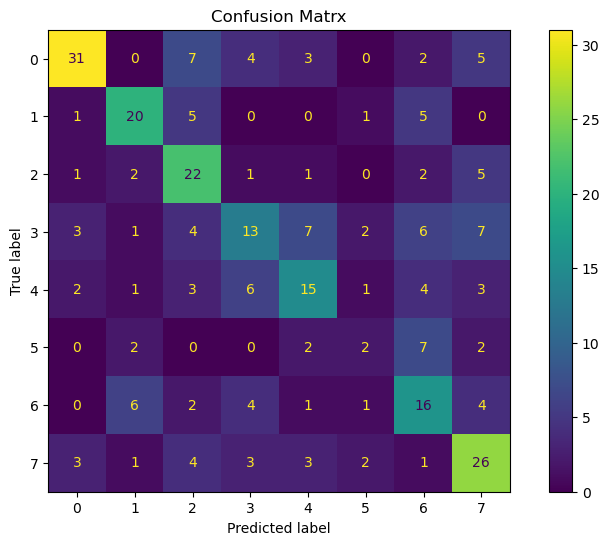

In [82]:
#Creating matplotlib axes object to assign figuresize and figure title
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx')

disp =metrics.plot_confusion_matrix(lm, X_test, y_test, ax = ax)
disp.confusion_matrix

In [110]:
 # Loss plotting
plt.plot(lm.history['loss'])
plt.plot(lm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


 # Accuracy plotting
plt.plot(lm.history['accuracy'])
plt.plot(lm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


AttributeError: 'LogisticRegression' object has no attribute 'history'

In [83]:
print(metrics.classification_report(y_test, lm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67        52
           1       0.61      0.62      0.62        32
           2       0.47      0.65      0.54        34
           3       0.42      0.30      0.35        43
           4       0.47      0.43      0.45        35
           5       0.22      0.13      0.17        15
           6       0.37      0.47      0.42        34
           7       0.50      0.60      0.55        43

    accuracy                           0.50       288
   macro avg       0.48      0.48      0.47       288
weighted avg       0.51      0.50      0.50       288



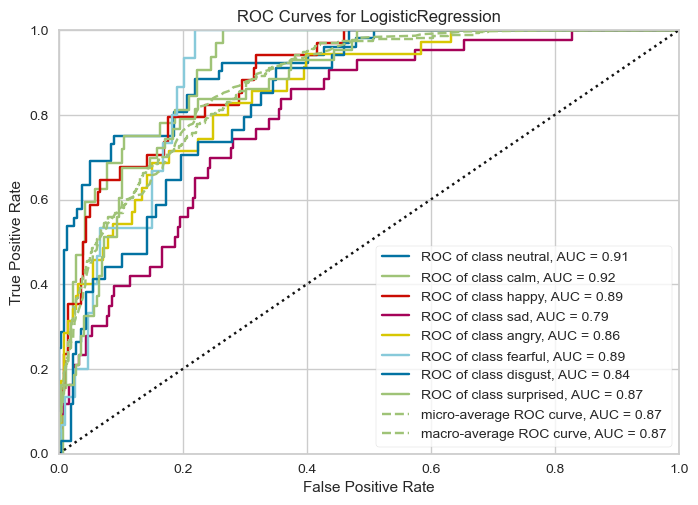

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [106]:
  
from yellowbrick.classifier import ROCAUC
# Creating visualization with the readable labels
visualizer = ROCAUC(lm, encoder={0:'neutral',1:'calm',2:'happy',3:'sad',4:'angry',5:'fearful',6:'disgust',7:'surprised'})
                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

MLP Classifier

In [63]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
#DataFlair - Train the model
mlp =model.fit(X_train,y_train)
#DataFlair - Predict for the test set
y_pred1=mlp.predict(X_test)
#DataFlair - Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred1)

#DataFlair - Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 66.32%


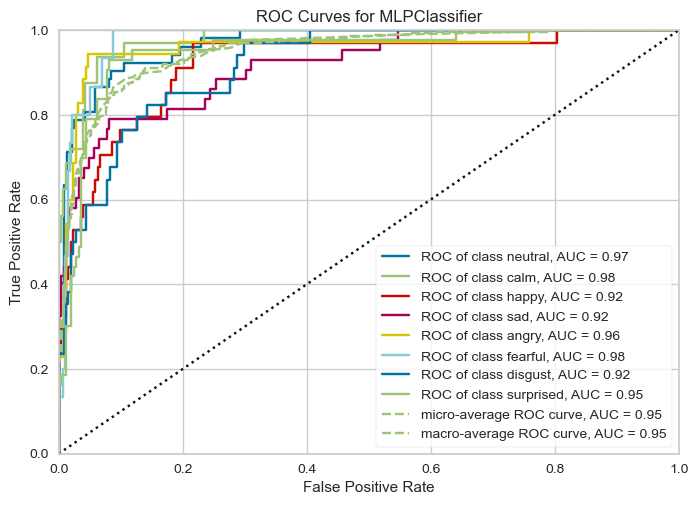

<AxesSubplot:title={'center':'ROC Curves for MLPClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [121]:
from yellowbrick.classifier import ROCAUC
# Creating visualization with the readable labels
visualizer = ROCAUC(mlp, encoder={0:'neutral',1:'calm',2:'happy',3:'sad',4:'angry',5:'fearful',6:'disgust',7:'surprised'})
                                        
# Fitting to the training data first then scoring with the test data                                    
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
#visualizer.title('ROC Curves for MLP Classifier')
visualizer.show()

array([[40,  1,  5,  2,  3,  0,  0,  1],
       [ 2, 22,  2,  0,  0,  5,  1,  0],
       [ 0,  1, 23,  1,  2,  1,  2,  4],
       [ 2,  0,  4, 30,  1,  0,  3,  3],
       [ 0,  0,  1,  3, 29,  0,  1,  1],
       [ 0,  1,  0,  1,  0, 12,  1,  0],
       [ 0,  3,  1,  4,  1,  4, 19,  2],
       [ 2,  1,  4,  0,  2,  1,  2, 31]])

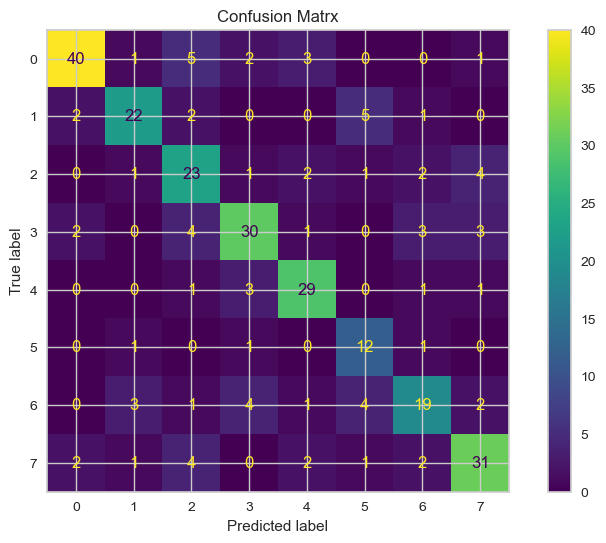

In [136]:
#Creating matplotlib axes object to assign figuresize and figure title
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Confusion Matrx MLP')

disp =metrics.plot_confusion_matrix(mlp, X_test, y_test, ax = ax)
disp.confusion_matrix

In [135]:
print(metrics.classification_report(y_test, mlp.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82        52
           1       0.76      0.69      0.72        32
           2       0.57      0.68      0.62        34
           3       0.73      0.70      0.71        43
           4       0.76      0.83      0.79        35
           5       0.52      0.80      0.63        15
           6       0.66      0.56      0.60        34
           7       0.74      0.72      0.73        43

    accuracy                           0.72       288
   macro avg       0.70      0.72      0.70       288
weighted avg       0.73      0.72      0.72       288



In [134]:
mlp.loss_curve_

<function list.count(value, /)>

In [65]:
#  # Loss plotting
# plt.plot(mlp.loss_curve_)
# plt.plot(mlp.loss)
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')


 # Accuracy plotting
plt.plot(mlp.history['accuracy'])
plt.plot(mlp.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


AttributeError: 'MLPClassifier' object has no attribute 'history'

In [255]:
plt.figure(figsize=(16,9))
#sns.set_style('whitegrid')
sns.pairplot(X)
plt.show()

TypeError: 'data' must be pandas DataFrame object, not: <class 'numpy.ndarray'>

<Figure size 1600x900 with 0 Axes>

In [64]:
roc_score = roc_auc_score(y_true,y_pred1,multi_class='ovr')
print(roc_score)

TypeError: Singleton array array(2) cannot be considered a valid collection.